In [1]:
#This file contains the code for Step2: Data Understanding.
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('du').getOrCreate()

In [2]:
#Import essential libraries.
from pyspark.sql.functions import col, when, mean as _mean, stddev as _stddev
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Function to set all the "NA" values to null.
def set_NA_to_null(dataset):
    attributes = dataset.columns
    for attr in attributes:
        dataset = dataset.withColumn(attr, when(col(attr) == "NA", None).otherwise(col(attr)))
        dataset = dataset.withColumn(attr, when(col(attr) == " ", None).otherwise(col(attr)))
    return dataset

In [4]:
#Function to check and print the amount of valid data in each column in the dataset.
def check_validation(dataset):
    attributes = dataset.columns
    for attr in attributes:
        valid_data = dataset.select(attr).na.drop()
        amount = valid_data.count()
        print(attr,"\t", amount)

In [5]:
#Function to check and print the completion of data in each column in the dataset.
def check_completion(dataset):
    attributes = dataset.columns
    instance_no = dataset.select("No").count()
    for attr in attributes:
        completion = dataset.select(attr).na.drop().count() / instance_no
        print(attr, "\t", round(completion *100,2), "%")

In [6]:
#Function to check and print the amount of outliers in each numeric column in the dataset.
def check_outliers(dataset):
    numeric_sub_dataset = dataset.drop("cbwd")
    attributes = numeric_sub_dataset.columns
    for attr in attributes:
        df_stats = numeric_sub_dataset.select( _mean(col(attr)).alias('mean'),
                                              _stddev(col(attr)).alias('std')).collect()
        mean = df_stats[0]['mean']
        std = df_stats[0]['std']
        lower_limit = mean - 3 * std
        upper_limit = mean + 3 * std
        lower_outliers = numeric_sub_dataset.filter(numeric_sub_dataset[attr] < lower_limit).select(attr)
        upper_outliers = numeric_sub_dataset.filter(numeric_sub_dataset[attr] > upper_limit).select(attr)
        amount_of_outliers = lower_outliers.count() + upper_outliers.count()
        print(attr,"\t", amount_of_outliers)

In [7]:
#Function to check and print the maximum and minumum value of each numeric column in the dataset.
def check_max_and_min(dataset):
    numeric_sub_dataset = dataset.drop("cbwd")
    sub_dataset = numeric_sub_dataset.toPandas()
    attributes = pd.Series(sub_dataset.columns)
    max_values = []
    min_values = []
    for attr in attributes:
        min_value = sub_dataset[attr].min()
        min_values.append(min_value)
        max_value = sub_dataset[attr].max()
        max_values.append(max_value)
    max_df = pd.Series(max_values, index = attributes.tolist(), name = 'Max')
    min_df = pd.Series(min_values, index = attributes.tolist(), name = 'Min')
    attrs = pd.Series(attributes.tolist(), index = attributes.tolist(), name = 'Attributes')
    max_min_df = pd.concat([attrs, min_df, max_df], axis = 1)
    return max_min_df

In [8]:
#read "Beijing PM2.5 Data" and show it.
dataset1 = spark.read.csv('./Datasets/PRSA_data_2010.1.1-2014.12.31.csv', inferSchema = True, header = True)
dataset1.show()

+---+----+-----+---+----+-----+----+-----+------+----+-----+---+---+
| No|year|month|day|hour|pm2.5|DEWP| TEMP|  PRES|cbwd|  Iws| Is| Ir|
+---+----+-----+---+----+-----+----+-----+------+----+-----+---+---+
|  1|2010|    1|  1|   0|   NA| -21|-11.0|1021.0|  NW| 1.79|  0|  0|
|  2|2010|    1|  1|   1|   NA| -21|-12.0|1020.0|  NW| 4.92|  0|  0|
|  3|2010|    1|  1|   2|   NA| -21|-11.0|1019.0|  NW| 6.71|  0|  0|
|  4|2010|    1|  1|   3|   NA| -21|-14.0|1019.0|  NW| 9.84|  0|  0|
|  5|2010|    1|  1|   4|   NA| -20|-12.0|1018.0|  NW|12.97|  0|  0|
|  6|2010|    1|  1|   5|   NA| -19|-10.0|1017.0|  NW| 16.1|  0|  0|
|  7|2010|    1|  1|   6|   NA| -19| -9.0|1017.0|  NW|19.23|  0|  0|
|  8|2010|    1|  1|   7|   NA| -19| -9.0|1017.0|  NW|21.02|  0|  0|
|  9|2010|    1|  1|   8|   NA| -19| -9.0|1017.0|  NW|24.15|  0|  0|
| 10|2010|    1|  1|   9|   NA| -20| -8.0|1017.0|  NW|27.28|  0|  0|
| 11|2010|    1|  1|  10|   NA| -19| -7.0|1017.0|  NW| 31.3|  0|  0|
| 12|2010|    1|  1|  11|   NA| -1

In [9]:
#Show the attributes of "Beijing PM2.5 Data".
dataset1 = dataset1.withColumnRenamed("pm2.5","pm")
dataset1.columns

['No',
 'year',
 'month',
 'day',
 'hour',
 'pm',
 'DEWP',
 'TEMP',
 'PRES',
 'cbwd',
 'Iws',
 'Is',
 'Ir']

In [10]:
#Show the amount of the instances of "Beijing PM2.5 Data".
dataset1.count()

43824

In [11]:
#Show the data types of the instances of "Beijing PM2.5 Data".
dataset1.printSchema()

root
 |-- No: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- pm: string (nullable = true)
 |-- DEWP: integer (nullable = true)
 |-- TEMP: double (nullable = true)
 |-- PRES: double (nullable = true)
 |-- cbwd: string (nullable = true)
 |-- Iws: double (nullable = true)
 |-- Is: integer (nullable = true)
 |-- Ir: integer (nullable = true)



In [12]:
#Call the function to set "NA" values to null for data quality verification.
dataset1 = set_NA_to_null(dataset1)
dataset1.show()

+---+----+-----+---+----+----+----+-----+------+----+-----+---+---+
| No|year|month|day|hour|  pm|DEWP| TEMP|  PRES|cbwd|  Iws| Is| Ir|
+---+----+-----+---+----+----+----+-----+------+----+-----+---+---+
|  1|2010|    1|  1|   0|null| -21|-11.0|1021.0|  NW| 1.79|  0|  0|
|  2|2010|    1|  1|   1|null| -21|-12.0|1020.0|  NW| 4.92|  0|  0|
|  3|2010|    1|  1|   2|null| -21|-11.0|1019.0|  NW| 6.71|  0|  0|
|  4|2010|    1|  1|   3|null| -21|-14.0|1019.0|  NW| 9.84|  0|  0|
|  5|2010|    1|  1|   4|null| -20|-12.0|1018.0|  NW|12.97|  0|  0|
|  6|2010|    1|  1|   5|null| -19|-10.0|1017.0|  NW| 16.1|  0|  0|
|  7|2010|    1|  1|   6|null| -19| -9.0|1017.0|  NW|19.23|  0|  0|
|  8|2010|    1|  1|   7|null| -19| -9.0|1017.0|  NW|21.02|  0|  0|
|  9|2010|    1|  1|   8|null| -19| -9.0|1017.0|  NW|24.15|  0|  0|
| 10|2010|    1|  1|   9|null| -20| -8.0|1017.0|  NW|27.28|  0|  0|
| 11|2010|    1|  1|  10|null| -19| -7.0|1017.0|  NW| 31.3|  0|  0|
| 12|2010|    1|  1|  11|null| -18| -5.0|1017.0|

In [13]:
#Call the function to check the amount of valid data.
check_validation(dataset1)

No 	 43824
year 	 43824
month 	 43824
day 	 43824
hour 	 43824
pm 	 41757
DEWP 	 43824
TEMP 	 43824
PRES 	 43824
cbwd 	 43824
Iws 	 43824
Is 	 43824
Ir 	 43824


In [14]:
#Change data type of pm2.5 to integer type.
dataset1 = dataset1.withColumn("pm",dataset1["pm"].cast(IntegerType()))
dataset1.printSchema()

root
 |-- No: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- pm: integer (nullable = true)
 |-- DEWP: integer (nullable = true)
 |-- TEMP: double (nullable = true)
 |-- PRES: double (nullable = true)
 |-- cbwd: string (nullable = true)
 |-- Iws: double (nullable = true)
 |-- Is: integer (nullable = true)
 |-- Ir: integer (nullable = true)



In [15]:
#Call the function to check the completion of each column.
check_completion(dataset1)

No 	 100.0 %
year 	 100.0 %
month 	 100.0 %
day 	 100.0 %
hour 	 100.0 %
pm 	 95.28 %
DEWP 	 100.0 %
TEMP 	 100.0 %
PRES 	 100.0 %
cbwd 	 100.0 %
Iws 	 100.0 %
Is 	 100.0 %
Ir 	 100.0 %


In [16]:
#Call the function to check the amount of outliers for each column.
check_outliers(dataset1)

No 	 0
year 	 0
month 	 0
day 	 0
hour 	 0
pm 	 769
DEWP 	 0
TEMP 	 0
PRES 	 0
Iws 	 1163
Is 	 256
Ir 	 613


In [17]:
#Call the function to get the maximum and minimum values for each column.
max_min_df = spark.createDataFrame(check_max_and_min(dataset1))
max_min_df.show()

+----------+------+-------+
|Attributes|   Min|    Max|
+----------+------+-------+
|        No|   1.0|43824.0|
|      year|2010.0| 2014.0|
|     month|   1.0|   12.0|
|       day|   1.0|   31.0|
|      hour|   0.0|   23.0|
|        pm|   0.0|  994.0|
|      DEWP| -40.0|   28.0|
|      TEMP| -19.0|   42.0|
|      PRES| 991.0| 1046.0|
|       Iws|  0.45|  585.6|
|        Is|   0.0|   27.0|
|        Ir|   0.0|   36.0|
+----------+------+-------+



In [18]:
#Get statistical data for "Is" and "Ir".
dataset1.select('Is','Ir').describe().show()

+-------+-------------------+-------------------+
|summary|                 Is|                 Ir|
+-------+-------------------+-------------------+
|  count|              43824|              43824|
|   mean|0.05273366192040891|0.19491602774735306|
| stddev| 0.7603747364300517| 1.4158667068673554|
|    min|                  0|                  0|
|    max|                 27|                 36|
+-------+-------------------+-------------------+



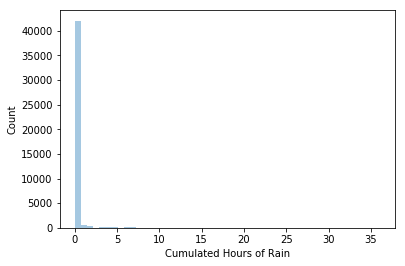

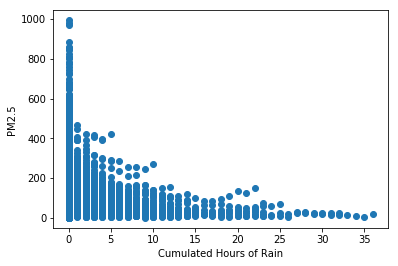

In [19]:
#Explore the data of cumulated hours of rain.
dataset1 = dataset1.toPandas()
pm25_b = dataset1["pm"]
ir = dataset1["Ir"]
sns.distplot(ir, kde=False)
plt.ylabel("Count")
plt.xlabel("Cumulated Hours of Rain")
plt.show()

plt.scatter(ir,pm25_b)
plt.ylabel("PM2.5")
plt.xlabel("Cumulated Hours of Rain")
plt.show()

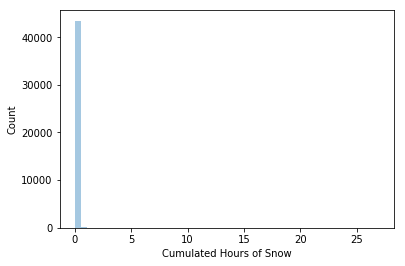

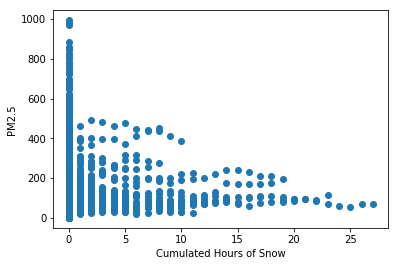

In [20]:
#Explore the data of cumulated hours of snow.
isnow = dataset1["Is"]
sns.distplot(isnow, kde=False)
plt.ylabel("Count")
plt.xlabel("Cumulated Hours of Snow")
plt.show()

plt.scatter(isnow,pm25_b)
plt.ylabel("PM2.5")
plt.xlabel("Cumulated Hours of Snow")
plt.show()

In [21]:
#read "PM2.5 Data of Five Chinese Cities (the Part of Beijing)" and show it.
dataset2 = spark.read.csv('./Datasets/BeijingPM20100101_20151231.csv', 
                          inferSchema = True, header = True)
dataset2.show(5)

+---+----+-----+---+----+------+---------+-------------+---------------+----------+----+----+----+----+----+-----+-------------+-----+
| No|year|month|day|hour|season|PM_Dongsi|PM_Dongsihuan|PM_Nongzhanguan|PM_US Post|DEWP|HUMI|PRES|TEMP|cbwd|  Iws|precipitation|Iprec|
+---+----+-----+---+----+------+---------+-------------+---------------+----------+----+----+----+----+----+-----+-------------+-----+
|  1|2010|    1|  1|   0|     4|       NA|           NA|             NA|        NA| -21|  43|1021| -11|  NW| 1.79|            0|    0|
|  2|2010|    1|  1|   1|     4|       NA|           NA|             NA|        NA| -21|  47|1020| -12|  NW| 4.92|            0|    0|
|  3|2010|    1|  1|   2|     4|       NA|           NA|             NA|        NA| -21|  43|1019| -11|  NW| 6.71|            0|    0|
|  4|2010|    1|  1|   3|     4|       NA|           NA|             NA|        NA| -21|  55|1019| -14|  NW| 9.84|            0|    0|
|  5|2010|    1|  1|   4|     4|       NA|           NA

In [22]:
#Show the attributes of "PM2.5 Data of Five Chinese Cities (the Part of Beijing)".
dataset2.columns

['No',
 'year',
 'month',
 'day',
 'hour',
 'season',
 'PM_Dongsi',
 'PM_Dongsihuan',
 'PM_Nongzhanguan',
 'PM_US Post',
 'DEWP',
 'HUMI',
 'PRES',
 'TEMP',
 'cbwd',
 'Iws',
 'precipitation',
 'Iprec']

In [23]:
#Show the amount of the instances of "PM2.5 Data of Five Chinese Cities (the Part of Beijing)".
dataset2.count()

52584

In [24]:
#Show the data types of the instances of "PM2.5 Data of Five Chinese Cities (the Part of Beijing)".
dataset2.printSchema()

root
 |-- No: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- season: integer (nullable = true)
 |-- PM_Dongsi: string (nullable = true)
 |-- PM_Dongsihuan: string (nullable = true)
 |-- PM_Nongzhanguan: string (nullable = true)
 |-- PM_US Post: string (nullable = true)
 |-- DEWP: string (nullable = true)
 |-- HUMI: string (nullable = true)
 |-- PRES: string (nullable = true)
 |-- TEMP: string (nullable = true)
 |-- cbwd: string (nullable = true)
 |-- Iws: string (nullable = true)
 |-- precipitation: string (nullable = true)
 |-- Iprec: string (nullable = true)



In [25]:
#Call the function to set "NA" values to null for data quality verification.
dataset2 = set_NA_to_null(dataset2)
dataset2.show(5)

+---+----+-----+---+----+------+---------+-------------+---------------+----------+----+----+----+----+----+-----+-------------+-----+
| No|year|month|day|hour|season|PM_Dongsi|PM_Dongsihuan|PM_Nongzhanguan|PM_US Post|DEWP|HUMI|PRES|TEMP|cbwd|  Iws|precipitation|Iprec|
+---+----+-----+---+----+------+---------+-------------+---------------+----------+----+----+----+----+----+-----+-------------+-----+
|  1|2010|    1|  1|   0|     4|     null|         null|           null|      null| -21|  43|1021| -11|  NW| 1.79|            0|    0|
|  2|2010|    1|  1|   1|     4|     null|         null|           null|      null| -21|  47|1020| -12|  NW| 4.92|            0|    0|
|  3|2010|    1|  1|   2|     4|     null|         null|           null|      null| -21|  43|1019| -11|  NW| 6.71|            0|    0|
|  4|2010|    1|  1|   3|     4|     null|         null|           null|      null| -21|  55|1019| -14|  NW| 9.84|            0|    0|
|  5|2010|    1|  1|   4|     4|     null|         null

In [26]:
#Call the function to check the amount of valid data.
check_validation(dataset2)

No 	 52584
year 	 52584
month 	 52584
day 	 52584
hour 	 52584
season 	 52584
PM_Dongsi 	 25052
PM_Dongsihuan 	 20508
PM_Nongzhanguan 	 24931
PM_US Post 	 50387
DEWP 	 52579
HUMI 	 52245
PRES 	 52245
TEMP 	 52579
cbwd 	 52579
Iws 	 52579
precipitation 	 52100
Iprec 	 52100


In [27]:
#Change data type of numeric data to integer or double type.
dataset2 = dataset2.withColumn("PM_Dongsi",dataset2["PM_Dongsi"].cast(IntegerType()))
dataset2 = dataset2.withColumn("PM_Dongsihuan",dataset2["PM_Dongsihuan"].cast(IntegerType()))
dataset2 = dataset2.withColumn("PM_Nongzhanguan",dataset2["PM_Nongzhanguan"].cast(IntegerType()))
dataset2 = dataset2.withColumn("PM_US Post",dataset2["PM_US Post"].cast(IntegerType()))
dataset2 = dataset2.withColumn("DEWP",dataset2["DEWP"].cast(IntegerType()))
dataset2 = dataset2.withColumn("HUMI",dataset2["HUMI"].cast(IntegerType()))
dataset2 = dataset2.withColumn("PRES",dataset2["PRES"].cast(IntegerType()))
dataset2 = dataset2.withColumn("TEMP",dataset2["TEMP"].cast(IntegerType()))
dataset2 = dataset2.withColumn("Iws",dataset2["Iws"].cast(DoubleType()))
dataset2 = dataset2.withColumn("precipitation",dataset2["precipitation"].cast(IntegerType()))
dataset2 = dataset2.withColumn("Iprec",dataset2["Iprec"].cast(IntegerType()))
dataset2.printSchema()

root
 |-- No: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- season: integer (nullable = true)
 |-- PM_Dongsi: integer (nullable = true)
 |-- PM_Dongsihuan: integer (nullable = true)
 |-- PM_Nongzhanguan: integer (nullable = true)
 |-- PM_US Post: integer (nullable = true)
 |-- DEWP: integer (nullable = true)
 |-- HUMI: integer (nullable = true)
 |-- PRES: integer (nullable = true)
 |-- TEMP: integer (nullable = true)
 |-- cbwd: string (nullable = true)
 |-- Iws: double (nullable = true)
 |-- precipitation: integer (nullable = true)
 |-- Iprec: integer (nullable = true)



In [28]:
#Call the function to check the completion of each column.
check_completion(dataset2)

No 	 100.0 %
year 	 100.0 %
month 	 100.0 %
day 	 100.0 %
hour 	 100.0 %
season 	 100.0 %
PM_Dongsi 	 47.64 %
PM_Dongsihuan 	 39.0 %
PM_Nongzhanguan 	 47.41 %
PM_US Post 	 95.82 %
DEWP 	 99.99 %
HUMI 	 99.36 %
PRES 	 99.36 %
TEMP 	 99.99 %
cbwd 	 99.99 %
Iws 	 99.99 %
precipitation 	 99.08 %
Iprec 	 99.08 %


In [29]:
#Call the function to check the amount of outliers for each column.
check_outliers(dataset2)

No 	 0
year 	 0
month 	 0
day 	 0
hour 	 0
season 	 0
PM_Dongsi 	 413
PM_Dongsihuan 	 394
PM_Nongzhanguan 	 470
PM_US Post 	 933
DEWP 	 0
HUMI 	 0
PRES 	 0
TEMP 	 0
Iws 	 1388
precipitation 	 1
Iprec 	 1


In [30]:
#Call the function to get the maximum and minimum values for each column.
max_min_df = spark.createDataFrame(check_max_and_min(dataset2))
max_min_df.show()

+---------------+------+--------+
|     Attributes|   Min|     Max|
+---------------+------+--------+
|             No|   1.0| 52584.0|
|           year|2010.0|  2015.0|
|          month|   1.0|    12.0|
|            day|   1.0|    31.0|
|           hour|   0.0|    23.0|
|         season|   1.0|     4.0|
|      PM_Dongsi|   3.0|   737.0|
|  PM_Dongsihuan|   3.0|   672.0|
|PM_Nongzhanguan|   3.0|   844.0|
|     PM_US Post|   1.0|   994.0|
|           DEWP| -40.0|    28.0|
|           HUMI|   2.0|   100.0|
|           PRES| 991.0|  1046.0|
|           TEMP| -19.0|    42.0|
|            Iws|  0.45|   585.6|
|  precipitation|   0.0|999990.0|
|          Iprec|   0.0|999990.0|
+---------------+------+--------+



In [31]:
#Get statistical data for "PM2.5 Data of Five Chinese Cities (the Part of Beijing)".
dataset2.select('PM_US Post').describe().show()
dataset2.select('DEWP','HUMI','PRES','TEMP').describe().show()
dataset2.select('Iws','precipitation','Iprec').describe().show()

+-------+-----------------+
|summary|       PM_US Post|
+-------+-----------------+
|  count|            50387|
|   mean|95.90424117331851|
| stddev|91.64377236804653|
|    min|                1|
|    max|              994|
+-------+-----------------+

+-------+------------------+-----------------+------------------+------------------+
|summary|              DEWP|             HUMI|              PRES|              TEMP|
+-------+------------------+-----------------+------------------+------------------+
|  count|             52579|            52245|             52245|             52579|
|   mean|2.0745544799254456|54.60231601110154| 1016.465403387884|12.587021434412978|
| stddev|14.222058604097723| 25.9913550673888|10.295032148686303|12.098526776991708|
|    min|               -40|                2|               991|               -19|
|    max|                28|              100|              1046|                42|
+-------+------------------+-----------------+------------------+--

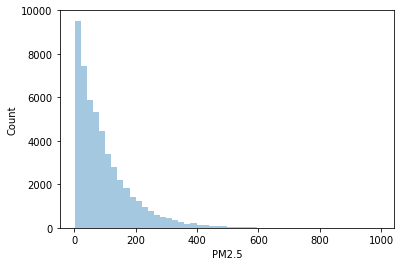

In [32]:
#Explore the data of PM2.5 concentration.
dataset2 = dataset2.toPandas()
pm25 = dataset2["PM_US Post"]
sns.distplot(pm25, kde=False)
plt.ylabel("Count")
plt.xlabel("PM2.5")
plt.show()

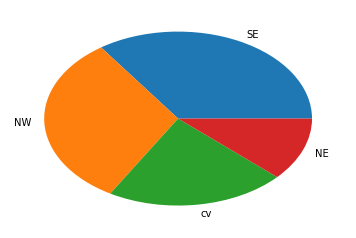

In [33]:
#Explore the data of combined wind speed.
cbwd_values = dataset2["cbwd"].value_counts()
plt.pie(cbwd_values, labels = cbwd_values.index)
plt.show()

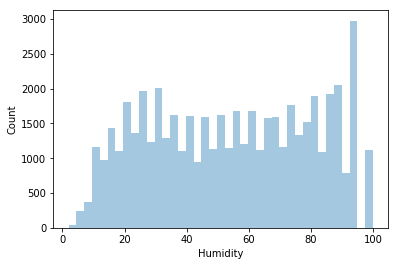

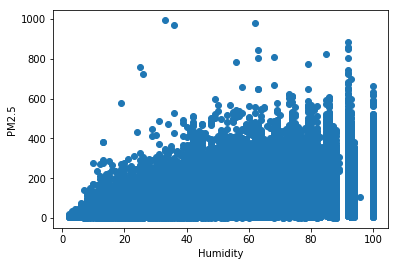

In [34]:
#Explore the data of humidity.
humi = dataset2["HUMI"]
sns.distplot(humi, kde=False)
plt.ylabel("Count")
plt.xlabel("Humidity")
plt.show()

plt.scatter(humi,pm25)
plt.ylabel("PM2.5")
plt.xlabel("Humidity")
plt.show()

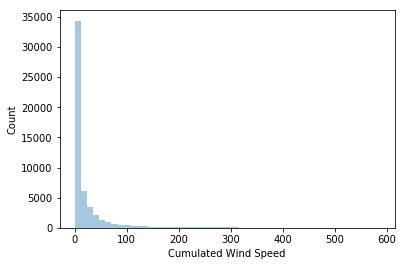

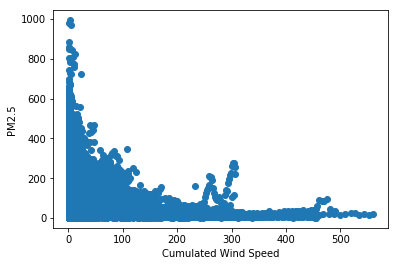

In [35]:
#Explore the data of cumulated wind speed.
iws = dataset2["Iws"]
sns.distplot(iws, kde=False)
plt.ylabel("Count")
plt.xlabel("Cumulated Wind Speed")
plt.show()

plt.scatter(iws,pm25)
plt.ylabel("PM2.5")
plt.xlabel("Cumulated Wind Speed")
plt.show()

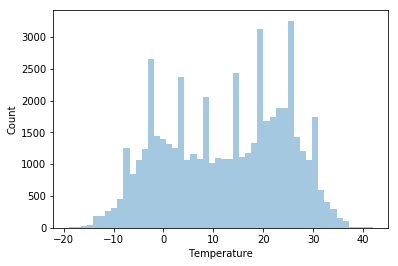

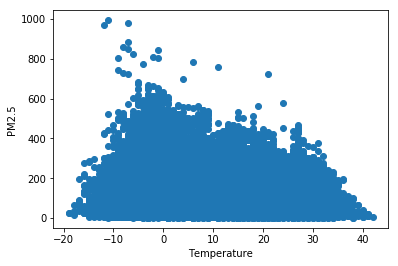

In [36]:
#Explore the data of temperature.
temp = dataset2["TEMP"]
sns.distplot(temp, kde=False)
plt.ylabel("Count")
plt.xlabel("Temperature")
plt.show()

plt.scatter(temp,pm25)
plt.ylabel("PM2.5")
plt.xlabel("Temperature")
plt.show()

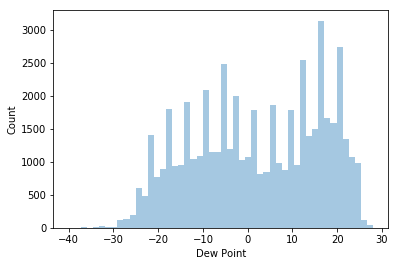

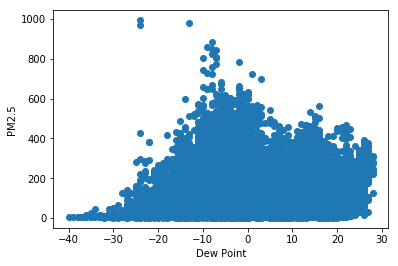

In [37]:
#Explore the data of dew point.
dewp = dataset2["DEWP"]
sns.distplot(dewp, kde=False)
plt.ylabel("Count")
plt.xlabel("Dew Point")
plt.show()

plt.scatter(dewp,pm25)
plt.ylabel("PM2.5")
plt.xlabel("Dew Point")
plt.show()

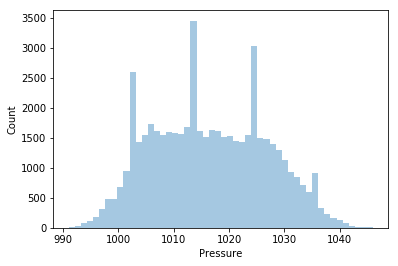

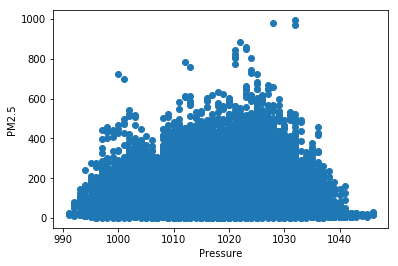

In [38]:
#Explore the data of pressure.
pres = dataset2["PRES"]
sns.distplot(pres, kde=False)
plt.ylabel("Count")
plt.xlabel("Pressure")
plt.show()

plt.scatter(pres,pm25)
plt.ylabel("PM2.5")
plt.xlabel("Pressure")
plt.show()